## Import the data and produce basic descriptive data analysis

Import Statements

In [6]:
import re
import io
import glob
import math
import sqlite3
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly.tools as tls
from dateutil import parser
import plotly.offline as py
from selenium import webdriver
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
pd.set_option('display.width',None)
py.init_notebook_mode(connected=True)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_rows',99999999)
from selenium.webdriver.common.action_chains import ActionChains

Import Primary Wildfire Dataset

In [7]:
%%time
# Create your connection.
sqlite_path = '/media/sagnikrana/DATA/Dataset/FPA_FOD_20170508.sqlite'
cnx = sqlite3.connect(sqlite_path)
df = pd.read_sql_query("SELECT * FROM Fires", cnx)

CPU times: user 31.7 s, sys: 2.54 s, total: 34.2 s
Wall time: 35.6 s


In [8]:
df.head().T

0  \
OBJECTID                                                                                                                      1   
FOD_ID                                                                                                                        1   
FPA_ID                                                                                                               FS-1418826   
SOURCE_SYSTEM_TYPE                                                                                                          FED   
SOURCE_SYSTEM                                                                                                       FS-FIRESTAT   
NWCG_REPORTING_AGENCY                                                                                                        FS   
NWCG_REPORTING_UNIT_ID                                                                                                  USCAPNF   
NWCG_REPORTING_UNIT_NAME                                                                                 Plumas National Forest   
SOURCE_REPORTING_UNIT                                                                                                      0511   
SOURCE_REPORTING_UNIT_NAME                                                                               Plumas National Forest   
LOCAL_FIRE_REPORT_ID                                                                                                          1   
LOCAL_INCIDENT_ID                                                                                                        PNF-47   
FIRE_CODE                                                                                                                  BJ8K   
FIRE_NAME                                                                                                              FOUNTAIN   
ICS_209_INCIDENT_NUMBER                                                                                                    None   
ICS_209_NAME                                                                                                               None   
MTBS_ID                                                                                                                    None   
MTBS_FIRE_NAME                                                                                                             None   
COMPLEX_NAME                                                                                                               None   
FIRE_YEAR                                                                                                                  2005   
DISCOVERY_DATE                                                                                                       2.4534e+06   
DISCOVERY_DOY                                                                                                                33   
DISCOVERY_TIME                                                                                                             1300   
STAT_CAUSE_CODE                                                                                                               9   
STAT_CAUSE_DESCR                                                                                                  Miscellaneous   
CONT_DATE                                                                                                            2.4534e+06   
CONT_DOY                                                                                                                     33   
CONT_TIME                                                                                                                  1730   
FIRE_SIZE                                                                                                                   0.1   
FIRE_SIZE_CLASS                                                                                                               A   
LATITUDE                                                         

Selenium webscraping for states

In [9]:
def is_number_regex(s):
    """ Returns True is string is a number. """
    if re.match("^\d+?\,\d+?$", s) is None:
        return s.isdigit()
    return True

browser_path = r"/home/sagnikrana/geckodriver"

driver = webdriver.Firefox(executable_path=browser_path)
driver.get("http://netstate.com/states/tables/st_size.htm")  # https://www.funderbeam.com/startups")
element = driver.find_element_by_xpath("/html/body/table/tbody/tr[2]/td[@id='contentcolumn']/table[@id='stripedtable']/tbody[2]")
details = element.text
details_1 = details.split("\n")
final = []
for entries in details_1:
    splitted = entries.split(" ")
    count = 1
    index1 = 0
    index2 = 0
    done = False
    num_range = []
    for value in splitted:
        res = is_number_regex(value)
        if count == 0 and res == True:
            continue
        if res == True and count > 0:
            index1 = count
            num_range.append(index1)
        count = count + 1
    if len(final) == 50:
        break
    final.append(splitted[num_range[1] : num_range[2]])
state_size = {}
for item in final:
    name = item[0:len(item)-1]
    value = item[-1]
    name_new = ""
    for string in name:
        if len(name) == 1:
            name_new = name_new + string
        if len(name) > 1:
            name_new = name_new + string + " "
    state_size[name_new] = value
state_size

{'Alabama': '50,750',
 'Alaska': '570,374',
 'Arizona': '113,642',
 'Arkansas': '52,075',
 'California': '155,973',
 'Colorado': '103,730',
 'Connecticut': '4,845',
 'Delaware': '1,955',
 'Florida': '53,997',
 'Georgia': '57,919',
 'Hawaii': '6,423',
 'Idaho': '82,751',
 'Illinois': '55,593',
 'Indiana': '35,870',
 'Iowa': '55,875',
 'Kansas': '81,823',
 'Kentucky': '39,732',
 'Louisiana': '43,566',
 'Maine': '30,865',
 'Maryland': '9,775',
 'Massachusetts': '7,838',
 'Michigan': '56,809',
 'Minnesota': '79,617',
 'Mississippi': '46,914',
 'Missouri': '68,898',
 'Montana': '145,556',
 'Nebraska': '76,878',
 'Nevada': '109,806',
 'New Hampshire ': '8,969',
 'New Jersey ': '7,419',
 'New Mexico ': '121,365',
 'New York ': '47,224',
 'North Carolina ': '48,718',
 'North Dakota ': '68,994',
 'Ohio': '40,953',
 'Oklahoma': '68,679',
 'Oregon': '96,003',
 'Pennsylvania': '44,820',
 'Rhode Island ': '1,045',
 'South Carolina ': '30,111',
 'South Dakota ': '75,898',
 'Tennessee': '41,220',
 'T

Merging the state square miles / acreage data to the original dataframe

In [10]:
##map state abbreviations to state data.  Convert mileage to acres.  Map it to the dataframe.
state_sizes = pd.DataFrame(state_size, index = ['State']).T.reset_index()
state_sizes.columns = ['State_Full', 'Square_Miles']
abbr_states = {
        'AK': 'Alaska',        'AL': 'Alabama',        'AR': 'Arkansas',        'AS': 'American Samoa',
        'AZ': 'Arizona',        'CA': 'California',        'CO': 'Colorado',        'CT': 'Connecticut',
        'DC': 'District of Columbia',        'DE': 'Delaware',        'FL': 'Florida',        'GA': 'Georgia',
        'GU': 'Guam',        'HI': 'Hawaii',        'IA': 'Iowa',        'ID': 'Idaho',
        'IL': 'Illinois',        'IN': 'Indiana',        'KS': 'Kansas',        'KY': 'Kentucky',
        'LA': 'Louisiana',        'MA': 'Massachusetts',        'MD': 'Maryland',        'ME': 'Maine',
        'MI': 'Michigan',        'MN': 'Minnesota',        'MO': 'Missouri',        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',        'MT': 'Montana',        'NA': 'National',        'NC': 'North Carolina',
        'ND': 'North Dakota',        'NE': 'Nebraska',        'NH': 'New Hampshire',        'NJ': 'New Jersey',
        'NM': 'New Mexico',        'NV': 'Nevada',        'NY': 'New York',        'OH': 'Ohio',
        'OK': 'Oklahoma',        'OR': 'Oregon',        'PA': 'Pennsylvania',        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',        'SC': 'South Carolina',        'SD': 'South Dakota',        'TN': 'Tennessee',
        'TX': 'Texas',        'UT': 'Utah',        'VA': 'Virginia',        'VI': 'Virgin Islands',
        'VT': 'Vermont',        'WA': 'Washington',        'WI': 'Wisconsin',        'WV': 'West Virginia',
        'WY': 'Wyoming'}

states_abbr = dict((v,k) for k,v in abbr_states.items())

state_sizes['STATE'] = [states_abbr[x.strip()] for x in state_sizes['State_Full']]
state_sizes['Square_Miles'] = [int(x.replace(',', '')) for x in state_sizes['Square_Miles']]
state_sizes['Acreage'] = [state_sizes.loc[x,'Square_Miles']*460 for x in state_sizes.index]
state_sizes = state_sizes.drop(columns=['State_Full'])

df = df.merge(state_sizes, on='STATE')

In [11]:
state_sizes.head()

Square_Miles STATE    Acreage
0         50750    AL   23345000
1        570374    AK  262372040
2        113642    AZ   52275320
3         52075    AR   23954500
4        155973    CA   71747580

In [12]:
df.head()

OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0         1       1  FS-1418826                FED   FS-FIRESTAT   
1         2       2  FS-1418827                FED   FS-FIRESTAT   
2         3       3  FS-1418835                FED   FS-FIRESTAT   
3         4       4  FS-1418845                FED   FS-FIRESTAT   
4         5       5  FS-1418847                FED   FS-FIRESTAT   

  NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME  \
0                    FS                USCAPNF    Plumas National Forest   
1                    FS                USCAENF  Eldorado National Forest   
2                    FS                USCAENF  Eldorado National Forest   
3                    FS                USCAENF  Eldorado National Forest   
4                    FS                USCAENF  Eldorado National Forest   

  SOURCE_REPORTING_UNIT SOURCE_REPORTING_UNIT_NAME LOCAL_FIRE_REPORT_ID  \
0                  0511     Plumas National Forest                    1   
1                  0503   Eldorado National Forest                   13   
2                  0503   Eldorado National Forest                   27   
3                  0503   Eldorado National Forest                   43   
4                  0503   Eldorado National Forest                   44   

  LOCAL_INCIDENT_ID FIRE_CODE FIRE_NAME ICS_209_INCIDENT_NUMBER ICS_209_NAME  \
0            PNF-47      BJ8K  FOUNTAIN                    None         None   
1                13      AAC0    PIGEON                    None         None   
2               021      A32W     SLACK                    None         None   
3                 6      None      DEER                    None         None   
4                 7      None  STEVENOT                    None         None   

  MTBS_ID MTBS_FIRE_NAME COMPLEX_NAME  FIRE_YEAR  DISCOVERY_DATE  \
0    None           None         None       2005       2453403.5   
1    None           None         None       2004       2453137.5   
2    None           None         None       2004       2453156.5   
3    None           None         None       2004       2453184.5   
4    None           None         None       2004       2453184.5   

   DISCOVERY_DOY DISCOVERY_TIME  STAT_CAUSE_CODE STAT_CAUSE_DESCR  CONT_DATE  \
0             33           1300              9.0    Miscellaneous  2453403.5   
1            133           0845              1.0        Lightning  2453137.5   
2            152           1921              5.0   Debris Burning  2453156.5   
3            180           1600              1.0        Lightning  2453189.5   
4            180           1600              1.0        Lightning  2453189.5   

   CONT_DOY CONT_TIME  FIRE_SIZE FIRE_SIZE_CLASS   LATITUDE   LONGITUDE  \
0      33.0      1730       0.10               A  40.036944 -121.005833   
1     133.0      1530       0.25               A  38.933056 -120.404444   
2     152.0      2024       0.10               A  38.984167 -120.735556   
3     185.0      1400       0.10               A  38.559167 -119.913333   
4     185.0      1200       0.10               A  38.559167 -119.933056   

   OWNER_CODE       OWNER_DESCR STATE COUNTY FIPS_CODE  FIPS_NAME  \
0         5.0              USFS    CA     63       063     Plumas   
1         5.0              USFS    CA     61       061     Placer   
2        13.0  STATE OR PRIVATE    CA     17       017  El Dorado   
3         5.0              USFS    CA      3       003     Alpine   
4         5.0              USFS    CA      3       003     Alpine   

                                                                                                 Shape  \
0  b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@\xe8d\xc2\x92_@^\xc0\xe0\xc...   
1  b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\xc0\x90\xc6U]nwC@T\xb6\xeej\xe2\x19^\xc0\x90\xc6U]...   
2  b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\xc0P\xbbf,\xf9}C@\xd0\xa5\xa0W\x13/^\xc0P\xbbf,\xf...   
3  b'\x00\x01\xad\x10\x00

In [13]:
#Export to csv for use in Tableau
df.to_csv("wildfire_fires.csv")

Reading in the second Wildfire dataset on reporting agencies 

In [14]:
%%time
# Create your connection.
cnx = sqlite3.connect(sqlite_path)
df2 = pd.read_sql_query("SELECT * FROM NWCG_UnitIDActive_20170109", cnx)

CPU times: user 50.1 ms, sys: 12.1 ms, total: 62.2 ms
Wall time: 76 ms


In [15]:
df2.head().T

0  \
OBJECTID                                          1   
UnitId                                      USAKCAN   
GeographicArea                                   AK   
Gacc                                        USAKACC   
WildlandRole                 Resource Provider Only   
UnitType                             Non-Government   
Department                                       NG   
Agency                                          ANC   
Parent                                         None   
Country                                          US   
State                                            AK   
Code                                            CAN   
Name            Calista Regional Native Corporation   

                                         1                               2  \
OBJECTID                                 2                               3   
UnitId                            USAKCEKX                        USAKCFFX   
GeographicArea                          AK                              AK   
Gacc                               USAKACC                         USAKACC   
WildlandRole      Incident Host Geographic        Incident Host Geographic   
UnitType                   US County/Local                 US County/Local   
Department                              AK                              AK   
Agency                                 C&L                             C&L   
Parent                                None                            None   
Country                                 US                              US   
State                                   AK                              AK   
Code                                  CEKX                            CFFX   
Name            Central Emergency Services  City Fairbanks Fire Department   

                                             3                         4  
OBJECTID                                     4                         5  
UnitId                                USAKCFMX                   USAKCFQ  
GeographicArea                              AK                        AK  
Gacc                                   USAKACC                   USAKACC  
WildlandRole          Incident Host Geographic  Incident Host Geographic  
UnitType                       US County/Local                US Federal  
Department                                  AK                       DOD  
Agency                                     C&L                      USAF  
Parent                                    None                      None  
Country                                     US                        US  
State                                       AK                        AK  
Code                                      CFMX                       CFQ  
Name            Central Mat-Su Fire Department   Clear Air Force Station

In [16]:
#Exporting for Tableau
df2.to_csv("wildfire_Units.csv")

In [17]:
df2.shape

(5867, 13)

In [18]:
#seeing where the agencies are located
df2['GeographicArea'].value_counts().head()

RM    1484
CA    1285
NW     755
SA     633
EA     401
Name: GeographicArea, dtype: int64

In [19]:
#seeing the role of the agencies
df2['WildlandRole'].value_counts().head()

Incident Host Geographic        5228
Dispatch/Coordination Center     328
Resource Provider Only           266
Fire/Radio Cashes                 29
Training Facility                  8
Name: WildlandRole, dtype: int64

In [20]:
#Seeing the unit type of the agencies
df2['UnitType'].value_counts().head()

US County/Local    3063
US Federal         1791
US State            692
Interagency         129
Non-Government      123
Name: UnitType, dtype: int64

Dataset Descriptive Statistics

In [21]:
df.describe()

OBJECTID        FOD_ID     FIRE_YEAR  DISCOVERY_DATE  \
count  1.858318e+06  1.858318e+06  1.858318e+06    1.858318e+06   
mean   9.311970e+05  5.310534e+07  2.003677e+03    2.453053e+06   
std    5.395006e+05  1.005107e+08  6.689415e+00    2.444545e+03   
min    1.000000e+00  1.000000e+00  1.992000e+03    2.448622e+06   
25%    4.647742e+05  4.996512e+05  1.998000e+03    2.451060e+06   
50%    9.293535e+05  1.056764e+06  2.004000e+03    2.453142e+06   
75%    1.393942e+06  1.908981e+07  2.009000e+03    2.455038e+06   
max    1.880465e+06  3.003484e+08  2.015000e+03    2.457388e+06   

       DISCOVERY_DOY  STAT_CAUSE_CODE     CONT_DATE       CONT_DOY  \
count   1.858318e+06     1.858318e+06  9.886330e+05  988633.000000   
mean    1.656027e+02     5.896303e+00  2.453237e+06     172.671935   
std     8.980114e+01     3.419845e+00  2.687558e+03      84.317026   
min     1.000000e+00     1.000000e+00  2.448622e+06       1.000000   
25%     9.100000e+01     3.000000e+00  2.450700e+06     102.000000   
50%     1.660000e+02     5.000000e+00  2.453466e+06     181.000000   
75%     2.310000e+02     9.000000e+00  2.455754e+06     232.000000   
max     3.660000e+02     1.300000e+01  2.457392e+06     366.000000   

          FIRE_SIZE      LATITUDE     LONGITUDE    OWNER_CODE  Square_Miles  \
count  1.858318e+06  1.858318e+06  1.858318e+06  1.858318e+06  1.858318e+06   
mean   7.533362e+01  3.700241e+01 -9.605128e+01  1.055774e+01  9.135526e+04   
std    2.512422e+03  5.828111e+00  1.651048e+01  4.414498e+00  7.455566e+04   
min    1.000000e-05  1.892304e+01 -1.788026e+02  0.000000e+00  1.045000e+03   
25%    1.000000e-01  3.292611e+01 -1.104668e+02  8.000000e+00  4.871800e+04   
50%    1.000000e+00  3.553330e+01 -9.242420e+01  1.400000e+01  5.791900e+04   
75%    3.300000e+00  4.087806e+01 -8.246796e+01  1.400000e+01  1.136420e+05   
max    6.069450e+05  7.033060e+01 -6.697089e+01  1.500000e+01  5.703740e+05   

            Acreage  
count  1.858318e+06  
mean   4.202342e+07  
std    3.429560e+07  
min    4.807000e+05  
25%    2.241028e+07  
50%    2.664274e+07  
75%    5.227532e+07  
max    2.623720e+08

In [22]:
#Seeing count of wildfires by state
df['STATE'].value_counts().head()

CA    189550
GA    168867
TX    142021
NC    111277
FL     90261
Name: STATE, dtype: int64

In [23]:
#seeing who owns the land of the wildfires
df['OWNER_DESCR'].value_counts()

MISSING/NOT SPECIFIED    1029032
PRIVATE                   314777
USFS                      188338
BIA                       106819
STATE OR PRIVATE           71880
BLM                        63278
STATE                      30756
NPS                        17458
FWS                        11995
TRIBAL                      8952
OTHER FEDERAL               6450
MUNICIPAL/LOCAL             4236
UNDEFINED FEDERAL           2206
COUNTY                      1841
BOR                          285
FOREIGN                       15
Name: OWNER_DESCR, dtype: int64

In [24]:
#Seeing who reported the fires
df['SOURCE_REPORTING_UNIT_NAME'].value_counts().head()

Georgia Forestry Commission           97844
Fire Department of New York           75461
South Carolina Forestry Commission    52064
Mississippi Forestry Commission       46396
Texas Forest Service                  42675
Name: SOURCE_REPORTING_UNIT_NAME, dtype: int64

In [25]:
#Seeing the basic causes of the fires
df['STAT_CAUSE_DESCR'].value_counts()

Debris Burning       429022
Miscellaneous        323664
Arson                281295
Lightning            278465
Equipment Use        147610
Missing/Undefined    144901
Campfire              76136
Children              61165
Smoking               52861
Railroad              33455
Powerline             14448
Fireworks             11500
Structure              3796
Name: STAT_CAUSE_DESCR, dtype: int64

# Question 1: Wildfire frequency and severity over time and states

### Question 1a) 
Has the annual frequency of wildfires increased over time? If so, what has been the rate of increase?  Has that increase been accelerating?

In [26]:
US_fires_per_year = pd.DataFrame(df['FIRE_YEAR'].value_counts())
US_fires_per_year.sort_index(inplace=True)
US_fires_per_year

FIRE_YEAR
1992      67968
1993      61981
1994      75947
1995      71467
1996      75571
1997      61441
1998      68356
1999      89355
2000      96416
2001      86586
2002      75654
2003      64639
2004      67394
2005      84328
2006     111472
2007      91879
2008      85360
2009      76634
2010      78138
2011      88060
2012      72756
2013      64746
2014      67710
2015      74460

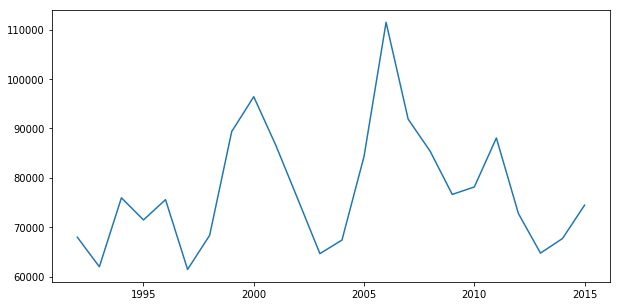

In [27]:
#Count of wildfires over time
plt.figure(figsize=(10,5))
plt.plot(US_fires_per_year.index, US_fires_per_year['FIRE_YEAR'])
plt.show()

In [28]:
#growth rate
avg_annual_growth = math.pow((US_fires_per_year.loc[2015] / US_fires_per_year.loc[1992]),
                           (1/len(US_fires_per_year))) -1

print("The average annual growth rate in fires between 1994 and 2015 was: \
{p:0.2f}%".format(p=avg_annual_growth*100))

The average annual growth rate in fires between 1994 and 2015 was: 0.38%


In [29]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    US_fires_per_year.index,US_fires_per_year['FIRE_YEAR'])

print("slope: {s:0.3f}".format(s=slope))
print("r-squared: {r:0.3f}".format(r=r_value))
print("p-value: {p:0.3f}".format(p=p_value))

slope: 286.811
r-squared: 0.166
p-value: 0.439


### Analysis for Q1a)

Surprisingly, the absolute number of wildfires in the U.S. has not shown a significant increase over the past 24 years.  The annualized growth rate is just 0.38% and in fact there is no statistically significant increase over that time frame.  However, there does appear to have been a consistent increase in wildfires between 1992 and 2006 before dropping off again from 2006 through 2015.  

This raises a new question: what was driving the increase between 1992 and 2006 and the subsequent drop-off through 2015?

### Question 1b)
How has the annual frequency of wildfires changed by state?  Are there any locations that stand out as contributors to the rise / fall of wildfires?

In [30]:
US_fires_per_year_by_state = pd.DataFrame(df.groupby([df['STATE'], df['FIRE_YEAR']]).size()).reset_index()
US_fires_per_year_by_state.columns = ['STATE', 'FIRE_YEAR', 'COUNT']
US_fires_per_year_by_state.sample(5)

STATE  FIRE_YEAR  COUNT
416     LA       2008   1438
304     IL       1992     18
156     CT       2004     87
1159    WY       2001    672
1039    VA       1997   1133

In [31]:
#top states in 1992, 2015

mask1992 = US_fires_per_year_by_state['FIRE_YEAR'] == 1992
mask2015 = US_fires_per_year_by_state['FIRE_YEAR'] == 2015

states1992 = US_fires_per_year_by_state[mask1992]
states2015 = US_fires_per_year_by_state[mask2015]

print(1992)
print(states1992.sort_values('COUNT', ascending=False).head())
print()
print(2015)
print(states2015.sort_values('COUNT', ascending=False).head())


states1992_2015 = states1992.merge(states2015, on = 'STATE')
    
states1992_2015['GROWTH'] = states1992_2015['COUNT_y'] / states1992_2015['COUNT_x']
states1992_2015['AVG_ANNUAL_GROWTH'] = (states1992_2015['GROWTH']**(1/(2015-1992+1))) -1
states1992_2015.sort_values('AVG_ANNUAL_GROWTH', ascending=False)


1992
    STATE  FIRE_YEAR  COUNT
96     CA       1992  10833
208    GA       1992   6459
615    NC       1992   5696
914    SC       1992   5195
567    MS       1992   4478

2015
     STATE  FIRE_YEAR  COUNT
1009    TX       2015   8304
119     CA       2015   7365
375     KS       2015   5887
806     NY       2015   5884
95      AZ       2015   3819


STATE  FIRE_YEAR_x  COUNT_x  FIRE_YEAR_y  COUNT_y      GROWTH  \
15    KS         1992       16         2015     5887  367.937500   
18    MA         1992        7         2015     2170  310.000000   
11    IA         1992        5         2015      517  103.400000   
44    VT         1992        1         2015       87   87.000000   
37    PA         1992       17         2015      807   47.470588   
34    OH         1992       21         2015      537   25.571429   
28    NE         1992       25         2015      599   23.960000   
1     AL         1992       93         2015     2074   22.301075   
33    NY         1992      364         2015     5884   16.164835   
16    KY         1992       49         2015      756   15.428571   
43    VA         1992       43         2015      597   13.883721   
19    MD         1992       12         2015      150   12.500000   
17    LA         1992       87         2015     1075   12.356322   
40    TN         1992       55         2015      612   11.127273   
2     AR         1992      128         2015     1289   10.070312   
41    TX         1992     1168         2015     8304    7.109589   
13    IL         1992       18         2015      106    5.888889   
7     DE         1992        3         2015       16    5.333333   
27    ND         1992      396         2015     1003    2.532828   
6     CT         1992      202         2015      372    1.841584   
39    SD         1992      554         2015      966    1.743682   
0     AK         1992      481         2015      771    1.602911   
29    NH         1992      107         2015      140    1.308411   
25    MT         1992     1642         2015     1866    1.136419   
22    MN         1992     1620         2015     1838    1.134568   
3     AZ         1992     3494         2015     3819    1.093017   
45    WA         1992     1774         2015     1741    0.981398   
47    WV         1992      701         2015      685    0.977175   
32    NV         1992      556         2015      526    0.946043   
21    MI         1992      614         2015      523    0.851792   
48    WY         1992      746         2015      632    0.847185   
35    OK         1992     1468         2015     1185    0.807221   
31    NM         1992      977         2015      778    0.796315   
46    WI         1992     1287         2015      965    0.749806   
4     CA         1992    10833         2015     7365    0.679867   
20    ME         1992      611         2015      406    0.664484   
36    OR         1992     3957         2015     2500    0.631792   
8     FL         1992     4222         2015     2548    0.603505   
12    ID         1992     2195         2015     1277    0.581777   
30    NJ         1992     1325         2015      770    0.581132   
42    UT         1992     1092         2015      605    0.554029   
24    MS         1992     4478         2015     2122    0.473872   
23    MO         1992     1680         2015      769    0.457738   
5     CO         1992     1322         2015      591    0.447050   
26    NC         1992     5696         2015     2471    0.433813   
9     GA         1992     6459         2015     2355    0.364608   
38    SC         1992     5195         2015     1299    0.250048   
14    IN         1992       95         2015       16    0.168421   
10    HI         1992       77         2015        4    0.051948   

    AVG_ANNUAL_GROWTH  
15           0.279108  
18           0.270009  
11           0.213217  
44           0.204518  
37           0.174495  
34           0.144607  
28           0.141507  
1            0.138100  
33           0.122942  
16           0.120762  
43           0.115846  
19           0.110976  
17           0.110441  
40           0.105604  
2            0.101016  
41           0.085159  
13           0.076675  
7            0.072239  
27           0.039482  
6            0.025769  
39           0.023437  
0            0.019854  
29           0.011264  
25           0.005343  
22

In [32]:
US_fires_per_year_by_state.groupby('STATE').head()

STATE  FIRE_YEAR  COUNT
0       AK       1992    481
1       AK       1993    861
2       AK       1994    640
3       AK       1995    418
4       AK       1996    718
24      AL       1992     93
25      AL       1993    137
26      AL       1994   3452
27      AL       1995   4230
28      AL       1996   4048
48      AR       1992    128
49      AR       1993    151
50      AR       1994    167
51      AR       1995    240
52      AR       1996    224
72      AZ       1992   3494
73      AZ       1993   4639
74      AZ       1994   4519
75      AZ       1995   4502
76      AZ       1996   3761
96      CA       1992  10833
97      CA       1993   8270
98      CA       1994   8654
99      CA       1995   7381
100     CA       1996   9173
120     CO       1992   1322
121     CO       1993   1244
122     CO       1994   2515
123     CO       1995   1517
124     CO       1996   1405
144     CT       1992    202
145     CT       1993    103
146     CT       1994    290
147     CT       1995    110
148     CT       1996     27
166     DE       1992      3
167     DE       1993      1
168     DE       1994      2
169     DE       1995      5
170     DE       1997      5
184     FL       1992   4222
185     FL       1993   4548
186     FL       1994   3530
187     FL       1995   3186
188     FL       1996   4697
208     GA       1992   6459
209     GA       1993   9111
210     GA       1994   6584
211     GA       1995   7968
212     GA       1996   9872
232     HI       1992     77
233     HI       1993     14
234     HI       1994      9
235     HI       1995     10
236     HI       1996      8
256     IA       1992      5
257     IA       1993      6
258     IA       1994      5
259     IA       1995      6
260     IA       1996     28
280     ID       1992   2195
281     ID       1993    698
282     ID       1994   3336
283     ID       1995   1433
284     ID       1996   1974
304     IL       1992     18
305     IL       1993      5
306     IL       1994     27
307     IL       1995     47
308     IL       1996     21
328     IN       1992     95
329     IN       1993     56
330     IN       1994     85
331     IN       1995    101
332     IN       1996     88
352     KS       1992     16
353     KS       1993     14
354     KS       1994     47
355     KS       1995     30
356     KS       1996     30
376     KY       1992     49
377     KY       1993     81
378     KY       1994    178
379     KY       1995    180
380     KY       1996     72
400     LA       1992     87
401     LA       1993    127
402     LA       1994    111
403     LA       1995    139
404     LA       1996    157
424     MA       1992      7
425     MA       1993      4
426     MA       1994      1
427     MA       1995     15
428     MA       1996      4
447     MD       1992     12
448     MD       1993     11
449     MD       1994     16
450     MD       1995     32
451     MD       1996     17
471     ME       1992    611
472     ME       1993    672
473     ME       1994    541
474     ME       1995    963
475     ME       1996    315
495     MI       1992    614
496     MI       1993    262
497     MI       1994    644
498     MI       1995    627
499     MI       1996    386
519     MN       1992   1620
520     MN       1993   1363
521     MN       1994   1904
522     MN       1995   1731
523     MN       1996   1752
543     MO       1992   1680
544     MO       1993    907
545     MO       1994   1607
546     MO       1995   2060
547     MO       1996    443
567     MS       1992   4478
568     MS       1993   4015
569     MS       1994   3356
570     MS       1995   4992
571     MS       1996   4923
591     MT       1992   1642
592     MT       1993    743
593     MT       1994   2984
594     MT       1995   1052
595     MT       1996   1993
615     NC       1992   5696
616     NC       1993   4808
617     NC       1994   5739
618     NC       1995   5253
619     NC       1996   4238
639     ND       1992    396
640     ND       1993    386
641

Plotting each state's count of wildfires

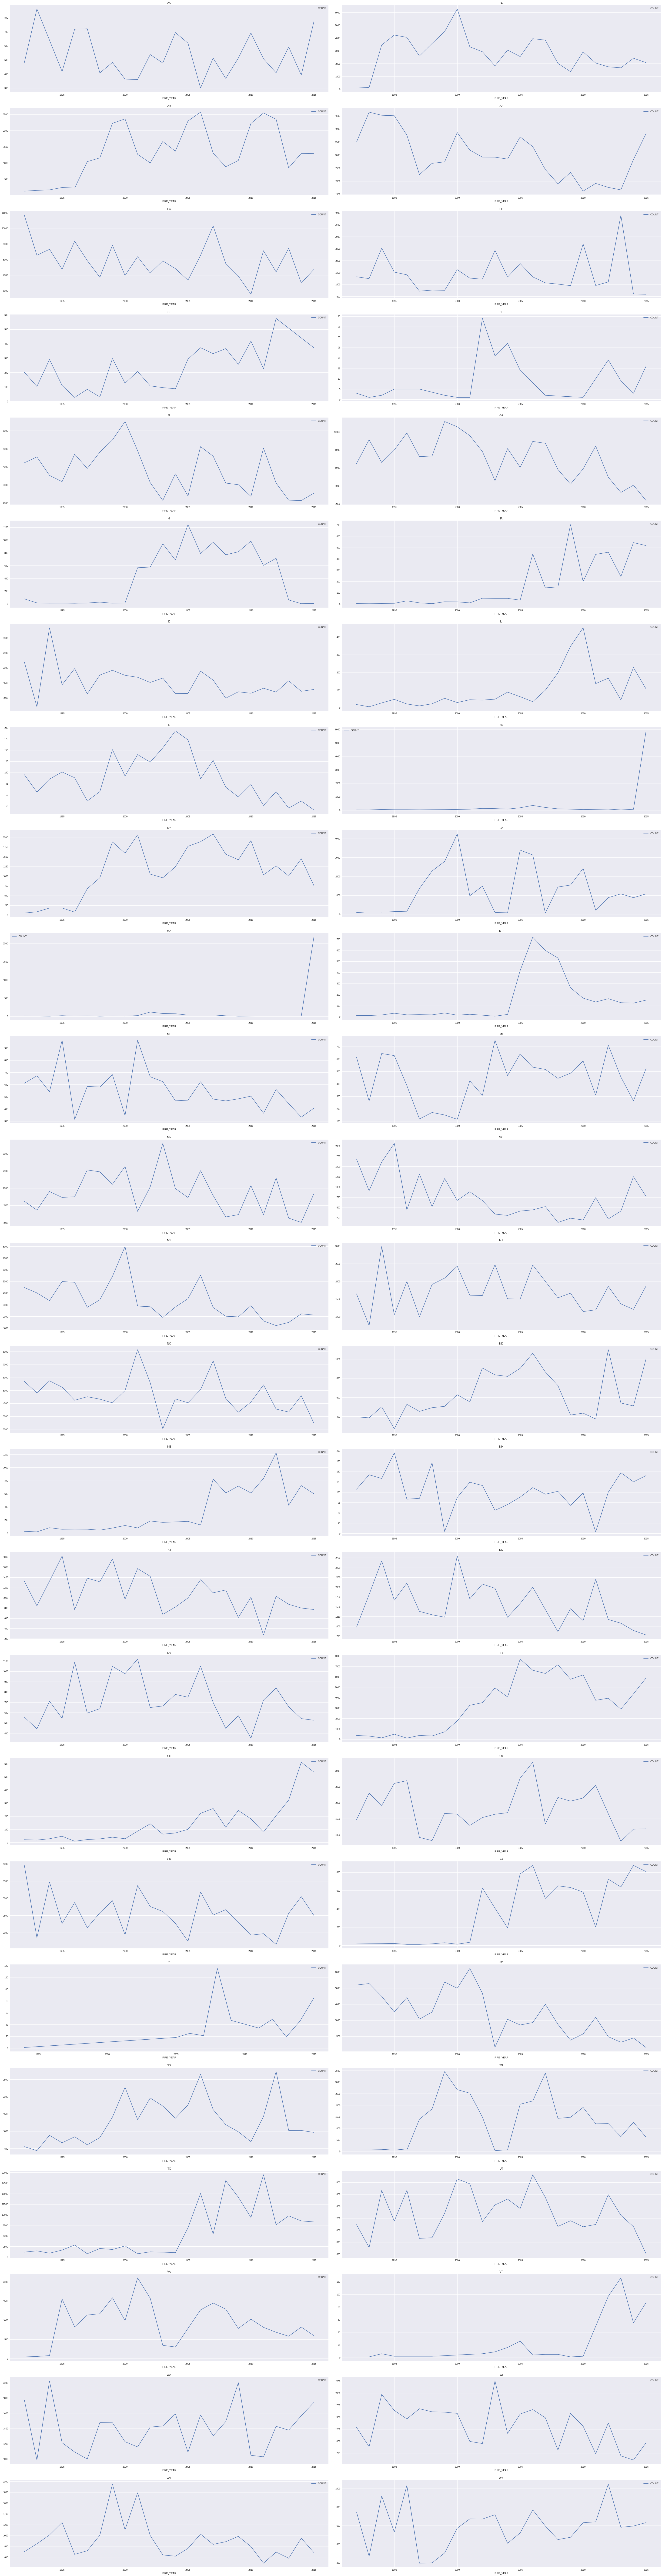

In [33]:
plt.figure(figsize=(40,160))
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 22})

fire_plots_by_state = US_fires_per_year_by_state.groupby('STATE') #create groupby object
for i, (state, data) in enumerate(fire_plots_by_state):#run through each group and print subplot
    
    #plotting
    ax = plt.subplot(26,2,i+1)
    data.plot(x= 'FIRE_YEAR', y = 'COUNT',ax=ax) 
    ax.set_title(state)

plt.tight_layout()
plt.show()

### Analysis for Question 1b)

Surprisingly, there has been a shift in the states that have the most wildfires.  In 1992, the top 5 states were as follows:

    STATE  FIRE_YEAR  COUNT
96     CA       1992  10833
228    GA       1992   6459
635    NC       1992   5696
954    SC       1992   5195
587    MS       1992   4478

However, in 2015, the counts switched:

     STATE  FIRE_YEAR  COUNT
1049    TX       2015   8304
119     CA       2015   7365
395     KS       2015   5887
826     NY       2015   5884
95      AZ       2015   3819


The states with the greatest increase over the time series were also somewhat unexpected.  Please note that a few states that have high growth rates have been omitted due to small absolute counts relative to the average or suspect data (e.g. Massachusetts and Kansas spiking up unreasonably):

New York saw a 12.23% annual increase from 364 to 5884.
Texas saw a 8.52% increase from 1168 to 8304, exceeding California's wildfire count by about 1000.

Some large states like California actually saw a decrease over time.

California's wildfire count fell -1.60%, while Georgia's saw a -4.11% decline.  Other big contributors saw declines, like North Carolina (-3.42%), South Carolina (-5.61%) and Mississippi (-3.06%).

I believe it would be helpful to plot these drops on a map to see if certain parts of the country are seeing lower fires.

In addition, it would be helpful to understand further why these states are seeing such increases/decreases.

## Question 1c) Fire size by year

Since we did not see an increase in the count of wildfires per year, we are curious to understand if the absolute size of fires has increased over time.  Simply put, are more acres being burned now than in the past due to larger fires?

In [34]:
#how many fires have size = 0?
years = df.FIRE_YEAR.unique()
print(type(years))
print("Year\t FireCount\t\t ZeroAreaCount\t Percent")
for year in np.sort(years):
    countFires = df.loc[df['FIRE_YEAR']==year]['FIRE_SIZE'].count()
    countZeroArea = df.loc[(df['FIRE_YEAR']==year) & (df['FIRE_SIZE']<10)]['FIRE_SIZE'].count()

    print(year,"\t", countFires,"\t\t\t", countZeroArea)

<class 'numpy.ndarray'>
Year	 FireCount		 ZeroAreaCount	 Percent
1992 	 67968 			 58517
1993 	 61981 			 52957
1994 	 75947 			 64719
1995 	 71467 			 60772
1996 	 75571 			 62965
1997 	 61441 			 53602
1998 	 68356 			 58859
1999 	 89355 			 75373
2000 	 96416 			 81176
2001 	 86586 			 75477
2002 	 75654 			 65803
2003 	 64639 			 56848
2004 	 67394 			 58474
2005 	 84328 			 70789
2006 	 111472 			 91224
2007 	 91879 			 78954
2008 	 85360 			 71880
2009 	 76634 			 65222
2010 	 78138 			 66906
2011 	 88060 			 73060
2012 	 72756 			 62318
2013 	 64746 			 57605
2014 	 67710 			 58948
2015 	 74460 			 64449


In [35]:
fire_by_year_size = df.groupby('FIRE_YEAR').sum()
fire_by_year_size.drop(columns=['OBJECTID', 'FOD_ID', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE'
                , 'CONT_DATE', 'CONT_DOY', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE',
                                'Square_Miles','Acreage'],inplace=True)

In [36]:
fire_by_year_size.head()

FIRE_SIZE
FIRE_YEAR              
1992       2.199831e+06
1993       2.191523e+06
1994       4.115670e+06
1995       2.049584e+06
1996       6.004654e+06

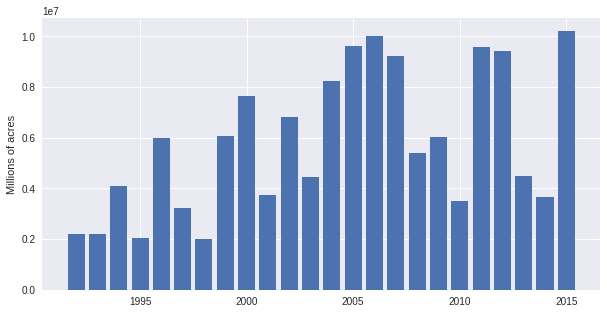

In [37]:
plt.figure(figsize=(10,5))
plt.bar(fire_by_year_size.index, fire_by_year_size['FIRE_SIZE'])
plt.ylabel("Millions of acres")
plt.style.use('seaborn')
plt.show()

In [38]:
#growth rate
avg_annual_growth_acre = math.pow((fire_by_year_size.loc[2015] / fire_by_year_size.loc[1992]),
                           (1/len(fire_by_year_size))) -1

print("The average annual growth rate in fire acreage between 1994 and 2015 was: \
{p:0.2f}%".format(p=avg_annual_growth_acre*100))

The average annual growth rate in fire acreage between 1994 and 2015 was: 6.61%


Identify the relative burn rate for each state so we can know what percent of the state burned in any given year.

In [39]:
US_fires_per_year_by_state_size = pd.DataFrame(df.groupby([df['STATE'], df['FIRE_YEAR']]).sum()).reset_index()
US_fires_per_year_by_state_size.drop(columns=['OBJECTID', 'FOD_ID', 'DISCOVERY_DATE', 
                                              'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 
                                              'CONT_DATE', 'CONT_DOY', 'LATITUDE', 
                                              'LONGITUDE', 'OWNER_CODE', 'Square_Miles','Acreage']
                                     ,inplace=True)
US_fires_per_year_by_state_size = US_fires_per_year_by_state_size.merge(state_sizes, on='STATE')
US_fires_per_year_by_state_size['Percent_land_burned'] =\
    US_fires_per_year_by_state_size['FIRE_SIZE']/US_fires_per_year_by_state_size['Acreage']

US_fires_per_year_by_state_size['Percent_land_burned'] =\
    US_fires_per_year_by_state_size['Percent_land_burned']*100 
US_fires_per_year_by_state_size.sort_values('Percent_land_burned', 
                                            ascending=False).head()

STATE  FIRE_YEAR   FIRE_SIZE  Square_Miles   Acreage  Percent_land_burned
295     ID       2007  2184656.24         82751  38065460             5.739209
300     ID       2012  1775106.39         82751  38065460             4.663299
1101    WA       2015  1161646.38         66582  30627720             3.792794
288     ID       2000  1350786.48         82751  38065460             3.548588
766     NV       1999  1773486.60        109806  50510760             3.511107

In [40]:
#Top 10 states in terms of average annual land burning
US_fires_per_year_by_state_size.groupby('STATE').mean().\
    sort_values('Percent_land_burned', ascending=False).head(10)

FIRE_YEAR     FIRE_SIZE  Square_Miles      Acreage  Percent_land_burned
STATE                                                                         
ID        2003.5  5.701806e+05       82751.0   38065460.0             1.497895
OR        2003.5  3.505334e+05       96003.0   44161380.0             0.793756
FL        2003.5  1.848645e+05       53997.0   24838620.0             0.744262
NV        2003.5  3.756606e+05      109806.0   50510760.0             0.743724
CA        2003.5  5.310774e+05      155973.0   71747580.0             0.740203
WA        2003.5  1.992591e+05       66582.0   30627720.0             0.650584
AK        2003.5  1.343046e+06      570374.0  262372040.0             0.511886
NM        2003.5  2.658351e+05      121365.0   55827900.0             0.476169
UT        2003.5  1.714553e+05       82168.0   37797280.0             0.453618
AZ        2003.5  2.323617e+05      113642.0   52275320.0             0.444496

In [41]:
US_fires_per_year_by_state_size.to_csv('StateBurnPercents.csv')

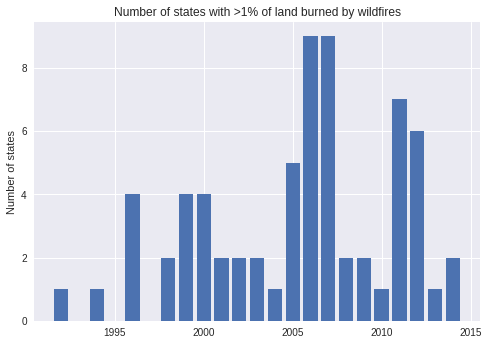

In [42]:
## number of states with >1% of land burned per year.
counts = {}

for year in range(1992,2015):
    count = US_fires_per_year_by_state_size.loc[(US_fires_per_year_by_state_size
                                                ['Percent_land_burned']>1) &
                                                (US_fires_per_year_by_state_size
                                                 ['FIRE_YEAR'] == year)]['STATE'].count()
    counts[year]=count

x = counts.keys()
y = counts.values()
plt.bar(x,y)
plt.title("Number of states with >1% of land burned by wildfires")
plt.ylabel("Number of states")
plt.show()

Plot the fire size for each state

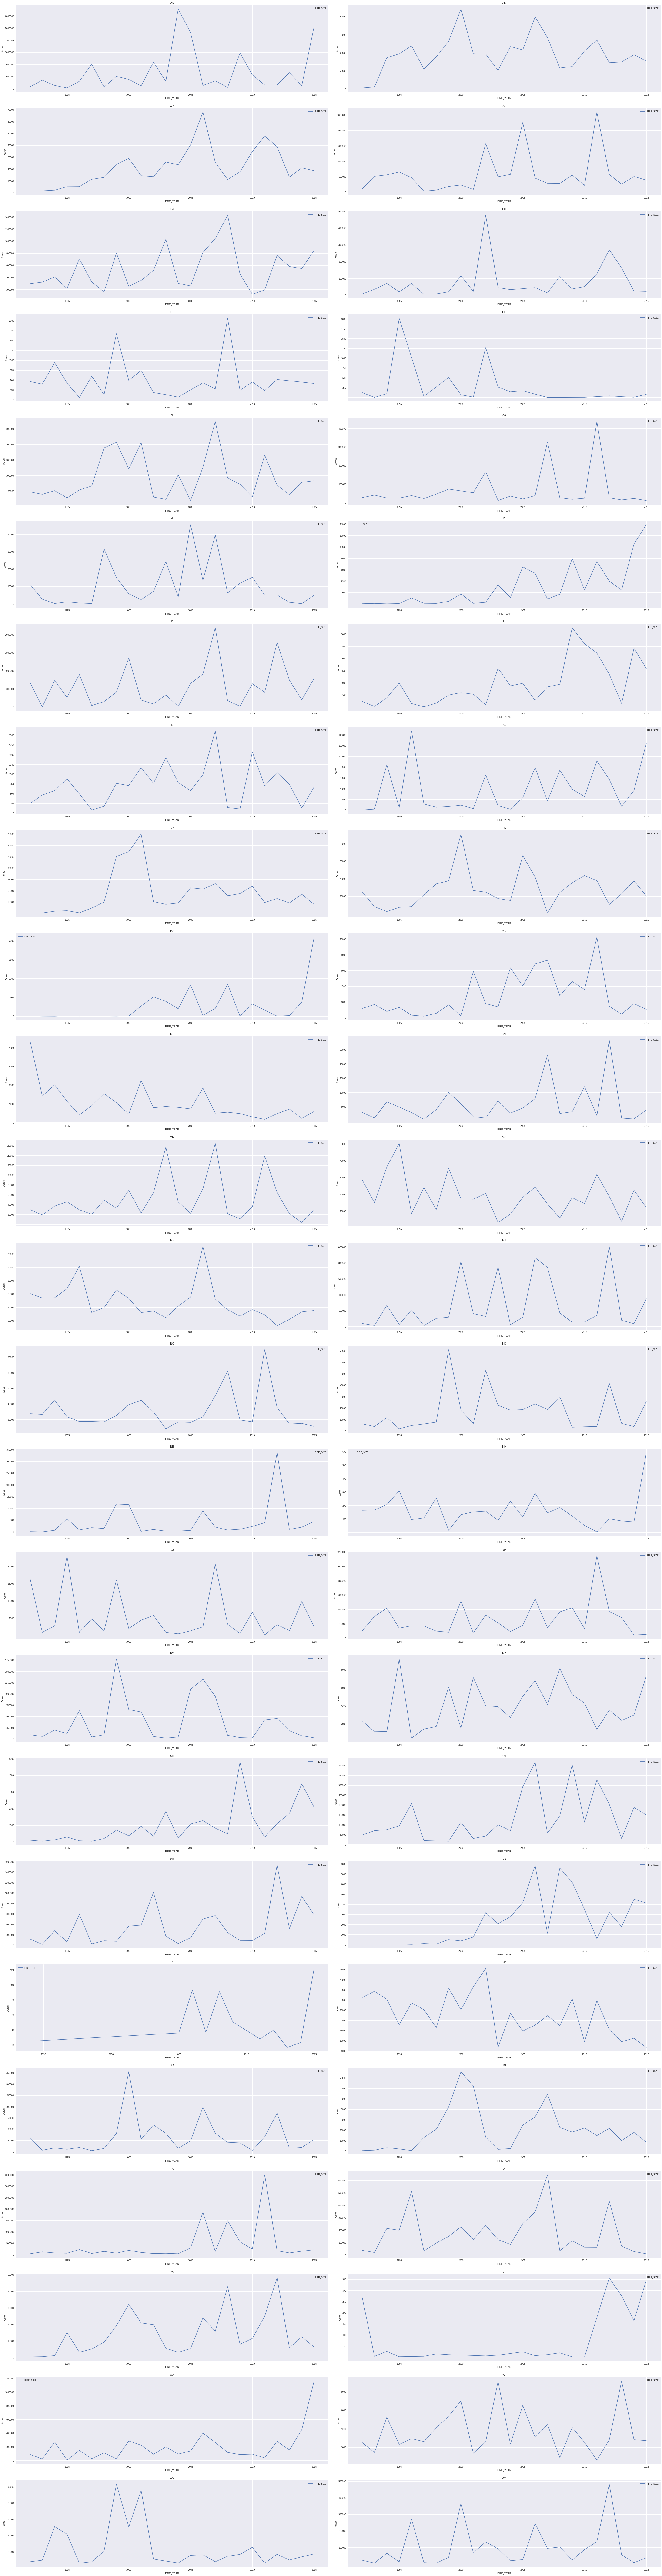

In [43]:
plt.figure(figsize=(40,160))
plt.rcParams.update({'font.size': 22})


fire_size_plots_by_state = US_fires_per_year_by_state_size.groupby('STATE')
for i, (state, data) in enumerate(fire_size_plots_by_state):#run through each group and print subplot

    ax = plt.subplot(26,2,i+1)
    data.plot(x= 'FIRE_YEAR', y = 'FIRE_SIZE',ax=ax)
    ax.set_ylabel('Acres')
    ax.set_title(state)

plt.tight_layout()
plt.show()

In [44]:
mask1992acre = US_fires_per_year_by_state_size['FIRE_YEAR'] == 1992
mask2015acre = US_fires_per_year_by_state_size['FIRE_YEAR'] == 2015

states1992 = US_fires_per_year_by_state_size[mask1992acre]
states2015 = US_fires_per_year_by_state_size[mask2015acre]

print(1992)
print(states1992.sort_values('FIRE_SIZE', ascending=False).head(7))
print()
print(2015)
print(states2015.sort_values('FIRE_SIZE', ascending=False).head(7))


states1992_2015 = states1992.merge(states2015, on = 'STATE')
    
states1992_2015['GROWTH'] = states1992_2015['FIRE_SIZE_y'] / states1992_2015['FIRE_SIZE_x']
states1992_2015['AVG_ANNUAL_GROWTH'] = (states1992_2015['GROWTH']**(1/(2015-1992+1))) -1
states1992_2015.sort_values('AVG_ANNUAL_GROWTH', ascending=False)

1992
    STATE  FIRE_YEAR  FIRE_SIZE  Square_Miles    Acreage  Percent_land_burned
280    ID       1992  684658.90         82751   38065460             1.798636
96     CA       1992  296439.80        155973   71747580             0.413170
0      AK       1992  142717.40        570374  262372040             0.054395
855    OR       1992  117437.36         96003   44161380             0.265928
735    NM       1992   99202.45        121365   55827900             0.177693
184    FL       1992   95279.70         53997   24838620             0.383595
759    NV       1992   92345.80        109806   50510760             0.182824

2015
     STATE  FIRE_YEAR   FIRE_SIZE  Square_Miles    Acreage  \
23      AK       2015  5136703.76        570374  262372040   
1101    WA       2015  1161646.38         66582   30627720   
119     CA       2015   848728.61        155973   71747580   
303     ID       2015   791026.11         82751   38065460   
878     OR       2015   579124.05         96003   44161

STATE  FIRE_YEAR_x  FIRE_SIZE_x  Square_Miles_x  Acreage_x  \
15    KS         1992      251.600           81823   37638580   
18    MA         1992        5.400            7838    3605480   
11    IA         1992       85.300           55875   25702500   
37    PA         1992       59.700           44820   20617200   
28    NE         1992     1227.100           76878   35363880   
0     AK         1992   142717.400          570374  262372040   
16    KY         1992      604.500           39732   18276720   
1     AL         1992     1253.200           50750   23345000   
34    OH         1992      101.700           40953   18838380   
40    TN         1992      429.600           41220   18961200   
43    VA         1992      434.600           39598   18215080   
45    WA         1992    89681.050           66582   30627720   
2     AR         1992     1478.500           52075   23954500   
25    MT         1992    38591.720          145556   66955760   
13    IL         1992      235.400           55593   25572780   
41    TX         1992    33610.300          261914  120480440   
36    OR         1992   117437.360           96003   44161380   
27    ND         1992     6373.900           68994   31737240   
3     AZ         1992    42593.650          113642   52275320   
29    NH         1992      164.671            8969    4125740   
35    OK         1992    47575.100           68679   31592340   
33    NY         1992     2334.400           47224   21723040   
5     CO         1992     7451.900          103730   47715800   
4     CA         1992   296439.800          155973   71747580   
14    IN         1992      247.300           35870   16500200   
47    WV         1992     7514.400           24087   11080020   
8     FL         1992    95279.700           53997   24838620   
48    WY         1992    22241.800           97105   44668300   
44    VT         1992      270.000            9249    4254540   
21    MI         1992     2987.400           56809   26132140   
12    ID         1992   684658.900           82751   38065460   
46    WI         1992     2520.610           54314   24984440   
22    MN         1992    30182.130           79617   36623820   
39    SD         1992    59412.280           75898   34913080   
19    MD         1992     1160.300            9775    4496500   
6     CT         1992      466.050            4845    2228700   
17    LA         1992    25129.100           43566   20040360   
7     DE         1992      124.000            1955     899300   
24    MS         1992    60830.100           46914   21580440   
31    NM         1992    99202.450          121365   55827900   
10    HI         1992    11161.300            6423    2954580   
9     GA         1992    27016.370           57919   26642740   
23    MO         1992    28716.000           68898   31693080   
26    NC         1992    27489.100           48718   22410280   
42    UT         1992    37531.910           82168   37797280   
32    NV         1992    92345.800          109806   50510760   
38    SC         1992    31202.800           30111   13851060   
30    NJ         1992    16603.650            7419    3412740   
20    ME         1992     4399.300           30865   14197900   

    Percent_land_burned_x  FIRE_YEAR_y   FIRE_SIZE_y  Square_Miles_y  \
15               0.000668         2015  1.242105e+05           81823   
18               0.000150         2015  2.094230e+03            7838   
11               0.000332         2015  1.391428e+04           55875   
37               0.000290         2015  4.136240e+03           44820   
28               0.003470         2015  4.419480e+04           76878   
0                0.054395         2015  5.136704e+06          570374   
16               0.003307         2015  1.968002e+04           39732   
1                0.005368         2015  3.083371e+04           50750   
34               0.000540         2015  2.084090e+03           40953   
40               0.002266       

![Interestingly, the vast majority of fires are really small.  Only a few are big.](FireClass.jpg)



<img src="./Images/FireClass.jpg"/>
(A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres).

![Fire Severity in the first five years of the dataset](Geo_Size(92-96).jpg)



<img src="./Images/Geo_Size(92-96).jpg"/>

![Fire Severity in the last five years of the dataset](Geo_Size(92-96).jpg)


<img src="./Images/Geo_Size(11-15).jpg"/>

## Question 1c) analysis

Clearly there is a a different conclusion when looking at acreage, with annual growth of 6.61% between 1992 and 2015.  There appear to be a few cycles in the late 2000s and early 2010s that deserve more review.

In terms of drivers, we can see a few select states seeing drastic increases in their fire sizes.  Ignoring smaller states (e.g. MA) and anomalous data (e.g. KS), we can see that the following states have seen the most drastic increase in fires by acre:

Nebraska, Alaska, Alabama, Washington, Arizona and Montana.

The following states have seen the greatest decrease:

South Carolina, Nevada, Utah, North Carolina, Missouri and Georgia.

##### Additional takeaways based on proportional fire sizes (i.e. once taking into account state size)

There were some surprises in terms of which states see the greatest percent of their land burn each year.  California is number 5 with just 0.74% of land mass burning each year.  Idaho sees 1.50% of its land burn each year.  It will be interesting to understand why this is (note, most of Idaho is federal land, so this is worth investigating further... are these planned fires?).  Oregon, Florida and Nevada are also in the top 5.  Florida is the only state not in the Western United States, so it will be interesting to understand what is unique about their fires, if anything. 

Another takeaway is in regards to the number of states with >1% of their land mass being burned each year.  There has been an increase over time, with huge spikes in 2007/8 and 2011/2012.  It will be interesting to understand the cause of the larger fire numbers in those years.

# Question 2 - Wildfire Causes

Can we identify a common cause of the fires?  If there are significant differences in the cause by state, there may be an opportunity to employ targeted policy by location.

![Causes of Large Fires 1992-2015](SizeCause_map_all.jpg)


<img src="./Images/SizeCause_map_all.jpg"/>

![Causes of Large Fires - Lightning 1992-2015](SizeCause_map_light.jpg)


<img src="./Images/SizeCause_map_light.jpg"/>

![Causes of Large Fires - 1992-2015](Causes_bar_all.jpg)


<img src="./Images/Causes_bar_all.jpg"/>

![Causes of Large Fires in Idaho - 1992-2015](ID_Causes.jpg)


<img src="./Images/ID_Causes.jpg"/>

#### Answer: 

As can be seen in the charts above, lightning is the clear leader when it comes to wildfires.  Lightning account for 71% of wildfire burned between 2004-2007, some of the worst hit years of the last two decades.  Over the long term, it was the leading cause in 59% of wildfires.  

The states with the biggest number of wildfires were caused predominantly by wildfires.  For instance, in the years which Alaska, Idaho, Washington and Oregon saw significant spikes, wildfires were the primary cause.  That said, there are some other states which had a greater presence of other causes.  In California, equipment use was also a large factor.  In the southeast, Arson and debris burning were big causes in the 90s, only to fall off in recent years.  Meanwhile, in Flordia, equipment use and railroads have been an issue.

The takeaway is that the majority of wildfires cannot be strictly prevented.  However, there could be improved monitoring of forests and more rapid responses to contain wildfires.  In those few states mentioned above with unique situations, there is an opportunity to enact policy changes to betterpay  attention to these preventable causes. 

# Question 3 - Wildfires by time of the year

### 3 a)
Which time of the year are most affected by wildfires from 1992 - 2015 ?  Have wildfires become more frequent in atypical months over time?

In [49]:

pd.set_option('display.max_rows',99999999)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',100)
pd.set_option('display.width',None)
plt.style.use('ggplot')

def convert_julian_to_date(date):
    '''
    This function changes the julian date to datetime
    '''
    epoch = pd.to_datetime(0, unit='s').to_julian_date()
    date1 = pd.to_datetime(date - epoch, unit='D')
    cleaned_date = date1.strftime('%d/%m/%Y')
    return cleaned_date

def change_str_datetime(string):
    '''
    This function changes the string to datetime
    '''
    dt = parser.parse(string)
    return dt

cnx = sqlite3.connect(sqlite_path)
df = pd.read_sql_query("SELECT * FROM Fires", cnx)
    
df['DISCOVERY_DATE'] = df['DISCOVERY_DATE'].apply(lambda x: convert_julian_to_date(x))
df['DISCOVERY_DATE'] = df['DISCOVERY_DATE'].apply(lambda x: change_str_datetime(x))
months = [x.month for x in df['DISCOVERY_DATE']]
years = [x.year for x in df['DISCOVERY_DATE']]

In [50]:
months_df = pd.DataFrame(months)
months_df_freq = pd.DataFrame(months_df[0].value_counts())
months_df_freq['year'] = months_df_freq.index
months_df_freq['year'] = pd.to_numeric(months_df_freq['year'])
months_df_freq.sort_values(by=['year'], inplace = True)
months_df_freq['year'] = months_df_freq['year'].map({1:'January',
                          2:'February',
                          3:'March',
                          4:'April',
                          5:'May',
                          6:'June',
                          7:'July',
                          8:'August',
                          9:'September',
                          10:'October',
                          11:'November',
                          12:'December'})


trace1 = go.Scatterpolar(r = months_df_freq[0].values.tolist(),
                             theta = months_df_freq['year'].tolist(),
                             fill  = "toself",name = "Number of wildfires - 1992 to 2015",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            )

layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = "counterclockwise",
                                                           showline = True,
                                                           linewidth = 2,
                                                           tickwidth = 2,
                                                           gridcolor = "yellow",
                                                           gridwidth = 2),
                                         angularaxis = dict(tickfont = dict(size = 10),
                                                            layer = "below traces"
                                                           ),
                                         bgcolor  = "lightcyan",
                                        ),
                            paper_bgcolor = "azure",
                            title = "Number of wildfires (1992-2015)",height = 700))

fig = go.Figure(data=[trace1], layout=layout)
py.iplot(fig)

### Question 3 b)
In the duration of 5 years, during which months the forest fires have occured the most number of times?

In [51]:
df_new = df.groupby('FIRE_YEAR')['DISCOVERY_DATE'].count()
df_1992 = df[df['FIRE_YEAR'].isin([1992,1993,1994,1995])]
df_1996 = df[df['FIRE_YEAR'].isin([1996,1997,1998,1999])]
df_2000 = df[df['FIRE_YEAR'].isin([2000,2001,2002,2003])]
df_2004 = df[df['FIRE_YEAR'].isin([2004,2005,2006,2007])]
df_2008 = df[df['FIRE_YEAR'].isin([2008,2009,2010,2011])]
df_2012 = df[df['FIRE_YEAR'].isin([2012,2013,2014,2015])]

In [52]:
months_2012 = [x.month for x in df_2012['DISCOVERY_DATE']]
months_2008 = [x.month for x in df_2008['DISCOVERY_DATE']]
months_2004 = [x.month for x in df_2004['DISCOVERY_DATE']]
months_2000 = [x.month for x in df_2000['DISCOVERY_DATE']]
months_1996 = [x.month for x in df_1996['DISCOVERY_DATE']]
months_1992 = [x.month for x in df_1992['DISCOVERY_DATE']]

In [53]:
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

def show_month_graphs(months, label):
    '''
    This function shows the percentage of the months's
    contribution in the forest fires.
    '''
    months_df = pd.DataFrame(months)
    months_df_freq = pd.DataFrame(months_df[0].value_counts())
    total_sum = months_df_freq[0].sum()
    percen_list = []
    for num in months_df_freq[0]:
        percen_list.append((num/total_sum) * 100)
    months_df_freq[1] = percen_list
    
    #***** Plotting the graphs*********
    

    months_df_freq[2] =  months_df_freq.index
    months_df_freq[2] = months_df_freq[2].map({1:'January',
                                              2:'February',
                                              3:'March',
                                              4:'April',
                                              5:'May',
                                              6:'June',
                                              7:'July',
                                              8:'August',
                                              9:'September',
                                              10:'October',
                                              11:'November',
                                              12:'December'})
    lab = months_df_freq[2].tolist()
    #values
    val = months_df_freq[1].values.tolist()
    # print(churn["LEAVE"].value_counts())
    trace = go.Pie(labels = lab ,
                   values = val ,
                   marker = dict(colors =  [ 'royalblue' ,'lime'],
                                 line = dict(color = "white",
                                             width =  1.3)
                                ),
                   rotation = 90,
                   hoverinfo = "label+value+text",
                   hole = 0.4
                  )
    layout = go.Layout(dict(title = "Forest fire contribution - Months (percentage): "+str(label),
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                           )
                      )

    data = [trace]
    fig = go.Figure(data = data,layout = layout)
    py.iplot(fig)



show_month_graphs(months_1992, 'Years 1992- 1995')
show_month_graphs(months_1996, 'Years 1996- 1999')
show_month_graphs(months_2000, 'Years 2000- 2003')
show_month_graphs(months_2004, 'Years 2004- 2007')
show_month_graphs(months_2008, 'Years 2008- 2011')
show_month_graphs(months_2012, 'Years 2012- 2015')

The above graphs shows that  April, March, June, July, August consist the highest percentage of forest fires.

### Question 3 c)
For the months which are highly affected by the forest fires(dense months) in the above graphs, how their collective contribution has changed over time ?

In [55]:
year_month_new = pd.DataFrame([years, months])
year_month = year_month_new.T
year_month = year_month.rename(columns = {0:'year',1:'month'})

year_month['month'] = year_month['month'].map({1:'January',
                          2:'February',
                          3:'March',
                          4:'April',
                          5:'May',
                          6:'June',
                          7:'July',
                          8:'August',
                          9:'September',
                          10:'October',
                          11:'November',
                          12:'December'})
dense_month_list = ['March','April','July','August','May','June']
data_month = []
year_list = []
for year in range(1992,2016):
    temp = year_month[year_month['year'] == year]
    total = pd.DataFrame(temp['month'].value_counts())
    total = total['month'].sum()
    temp_month = temp[temp['month'].isin(['March','April','July','August','May','June'])]
    total_month = pd.DataFrame(temp_month['month'].value_counts())
    total_month = total_month['month'].sum()
    data_month.append((total_month/total)*100)
    year_list.append(year)


In [56]:
trace2 = go.Bar(x=year_list,
               y=data_month,
                marker=dict(
                color='blue')
                )

data = [trace2]

layout = go.Layout(
    title='Trend of forest fires in dense months (1992 - 2015)',
    xaxis=dict(
        title = 'Dense Month'
    ),
    yaxis=dict(
        title='Percentage wrt other months in the year',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    bargap=0.2,
    plot_bgcolor  = "lightcyan",
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

For the dense months - March, April, July, August, we can see that it has contributed nearly 60% of the fires with respect to other months. We need to be more careful about these months and necessary policies should be implemented when we approach these months.

### Question 3 d)
Is there any expansion in the window for forest fires ? Plot the fire frequency distrbution graph against months for first 5 years and last 5 years and explain if any discrepancy exists.

In [57]:
temp = year_month[year_month['year'].isin([1992,1993,1994,1995])]
total = pd.DataFrame(temp['month'].value_counts())
temp1 = year_month[year_month['year'].isin([2012,2013,2014,2015])]
total1 = pd.DataFrame(temp1['month'].value_counts())

trace1 = go.Scatterpolar(r = total['month'].values.tolist(),
                             theta = list(total.index),
                             fill  = "toself",name = "Number of wildfires - 1992 to 1995",
                             mode = "markers+lines",
                             marker = dict(size = 5),
                            )

trace2 = go.Scatterpolar(r = total1['month'].values.tolist(),
                             theta = list(total.index),
                             fill  = "toself",name = "Number of wildfires - 2012 to 2015",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            )


layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = "counterclockwise",
                                                           showline = True,
                                                           linewidth = 2,
                                                           tickwidth = 2,
                                                           gridcolor = "yellow",
                                                           gridwidth = 2),
                                         angularaxis = dict(tickfont = dict(size = 10),
                                                            layer = "below traces"
                                                           ),
                                         bgcolor  = "lightcyan",
                                        ),
                            paper_bgcolor = "azure",
                            title = "Wildfire comparision",height = 700))

fig = go.Figure(data=[trace1, trace2], layout=layout)
py.iplot(fig)

In the above graph, we can see that the window for forest fires has shifted from April, July March towards the fall and winter months, ie..October, November and December.

# Question 4: Effect of rainfall on Forest Wildfires

### Is there any relation between rainfall and wildfires ?

# Ubuntu Shell code to open all tar.z files for rainfall data

root@LAPTOP-1NUE2BLM:/mnt/c/Users/oldye/documents/cmu_2018/Spring2019/DataScience_BigData_95885/project1/Data/rain# for folder in ./states/*; do for file in *.tar.Z; do tar -zxf "$file"; done

for file in *.tar.Z; do tar -zxf "$file"; done

The below code is used to extract and parse the raw data of rainfall.
As the data is huge, we need to load the data in chunks by changing the range everytime. Below code reflects the loading the last chunk of data.

In [58]:
# # Code for the final bucket
# import pandas as pd
# import numpy as np
# import re
# import glob

# path_list = []

# for i in range(55,56):
#     if i<10:
#         path_list.append('/media/sagnikrana/DATA/PDS/0'+str(i)+'/*.dat')
#     else:
#         path_list.append('/media/sagnikrana/DATA/PDS/'+str(i)+'/*.dat')
# path_list

# state_code = []
# year = []
# month = []
# station = []
# precep_value = []
# counter = 1
# for path in path_list:
#     ham_list = glob.glob(path)
#     print('reading path - ',path)
#     read = []
#     for file in ham_list:
#         file_read = open(file).read()
#         read.append(file_read)
#         file = None

#     for doc in read:
#         file = doc.split("\n")
#         for content in file:
#             state_code.append(content[3:5])
#             year.append(content[17:21])
#             month.append(content[21:23])
#             station.append(content[3:11])
#             counter = counter + 1
#             if len(content[35:41].strip()) > 5:
#                 precep_value.append(0)
#             else:
#                 precep_value.append(content[35:41].strip())
#         file = None


In [59]:
# main = (pd.DataFrame([state_code, year, month, precep_value, station])).T
# main.rename(columns = {0:'state', 1:'year', 2:'month', 3:'precepitation', 4:'station'}, inplace = True)
# main.to_csv("/media/sagnikrana/DATA/PDS/output4", index = False, sep=',')

In [60]:
# def get_single_dataframe(pathname1):
#     df = pd.read_csv(pathname1)
#     df = df.dropna()
#     return df

# path = "/media/sagnikrana/DATA/PDS/"
# filename_list = ['output','output1','output2','output3','output4']
# pathname = [path + path_loop for path_loop in filename_list]
# df_list = []
# for pathname1 in pathname:
#     df_list.append(get_single_dataframe(pathname1))

# master_data = pd.concat(df_list)
# master_data.info()

In [61]:
# # Filtering the master data as per our range of years
# master_data_filt = master_data[master_data['year'] >= 1992]
# master_data_filt.head()

In [62]:
# states = list(master_data_filt['state'].unique())

# years = list(master_data_filt['year'].unique())

# state_1 = []
# year_1 = []
# unique_stat = []
# precip = []
# for state in states:
#     for year in years:
#         temp = master_data_filt[(master_data_filt['state'] == state) & (master_data_filt['year'] == year)]
#         unique_station = list(temp['station'].unique())
#         state_1.append(state)
#         year_1.append(year)
#         precip.append(temp['precipitation'].sum())
#         unique_stat.append(len(unique_station))

In [63]:
# # Storing the data to the disk
# df = pd.DataFrame([state_1, year_1, unique_stat, precip])
# df = df.T
# df['normalized_precep'] = df[3] / df[2]
# df.columns
# df.rename(columns = {0:'state', 1:'year', 2:'unique_stations', 3:'precipitations'}, inplace = True)
# df.head()

# df.to_csv('/media/sagnikrana/DATA/PDS/rainfall')

Data pre-processing done. Plotting the actual graph:

In [64]:
# Reading the rainfall data

rainfall = pd.read_csv('/media/sagnikrana/DATA/PDS/rainfall')
rainfall_list_actual = []
for year in range(1992,2014):
    temp = rainfall[rainfall['year'] == year]
    summation_precep_1 = temp['precepitations'].sum()
    rainfall_list_actual.append(summation_precep_1)

trace1 = go.Bar(x=fire_by_year_size.index,
           y=fire_by_year_size['FIRE_SIZE'],
                name = 'Number of wildfires',
            marker=dict(
            color='blue'),
                    hoverinfo= "x+y+text"
            )

trace2 = go.Line(x=fire_by_year_size.index,
                     y=rainfall_list_actual,
                 name = 'Precipitation',
                     marker=dict(
                     color='cyan'),
                     yaxis='y2',
                     hoverinfo= "x+y+text"
                    )


data = [trace1, trace2]

layout = go.Layout(
  title='Precipitation vs No. of wildfires - All States',
    yaxis=dict(
        title='Number of wildfires in millions'
    ),
    yaxis2=dict(
        title='Precipitation in 0.1 inches',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

#*******************************
# Graph for top states

state_code = [50.0, 4.0, 10.0, 45]
state_name = ['Alaska','California','Idaho','Washington']
i = 0
for state in state_code:
    rainfall_list = []
    for year in range(1992,2014):
        temp = rainfall[(rainfall['year'] == year) & (rainfall['state'] == state)]
        summation_precep = temp['precepitations'].sum()
        rainfall_list.append(summation_precep)
    trace1 = go.Bar(x=fire_by_year_size.index,
           y=fire_by_year_size['FIRE_SIZE'],
            name = 'Number of wildfires',
            marker=dict(
            color='blue'),
                    hoverinfo= "x+y+text"
            
            )

    trace2 = go.Line(x=fire_by_year_size.index,
                     y=rainfall_list,
                     name = 'Precipitation',
                     marker=dict(
                     color='red'),
                     yaxis='y2',
                     hoverinfo= "x+y+text"
                    )


    data = [trace1, trace2]

    layout = go.Layout(
      title='State - '+str(state_name[i]),
        yaxis=dict(
            title='Number of wildfires in millions'
        ),
        yaxis2=dict(
            title='Precepitation in .001 inches',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    i = i + 1

/home/sagnikrana/my_project_dir/my_project_env/lib/python3.5/site-packages/plotly/graph_objs/_deprecations.py:372: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




We can see there is a correlation between the precipitation and number of forest wildfires. Over the course of 24 years, it's evident that the amount of rainfall has decreased and number of wildfires have increased.